### Cohort Overview for Multi-omics characterizing ctDNA release phenotype

In [93]:
# load data


In [ ]:
# load libraris
suppressMessages({
    library(dplyr)
    library(ggplot2)
})
list_color <- c('#cc3333', '#339933', "#003399")
project_dir <- '/mnt/storageBig8/work/nguyenma/projects/ctDNA/ctDNA_release/ctDNArelease_Omics_Integration'
# load data
cohort <- read.delim(paste0(project_dir, "/data/ctdna_at_diagnosis.tsv"))
clinical <- read.delim(paste0(project_dir, "/data/ctdna_clinical_data.tsv"))

ctdna_cohort <- cohort %>%
    filter(histology != "benign") %>%
    mutate(ctdna_pheno = ifelse(TF > 0.01417, "positive", "negative")) %>%
    inner_join(clinical |> dplyr::rename(disease_detail = histology)) 

Joining with `by = join_by(patientID)`


In [101]:
df = cohort %>%
    left_join(
        clinical %>%
            dplyr::select(patientID, stage)
    ) %>%
    mutate(Stage = ifelse(stage %in% c('I','II'), 'Early', stage))

thresh1 = max(df[df$histology == 'benign',]$TF)
thresh2 = 0.065

Joining with `by = join_by(patientID)`


#### Figure 1a and 1b

In [102]:
#### visualisation - ctdna TF between stages
comp1 <- list(c('Benign\n(n=10)','Early\n(n=14)'),
              c('Benign\n(n=10)','III\n(n=85)'),
              c('Benign\n(n=10)','IV\n(n=19)'),
              c('Early\n(n=14)','IV\n(n=19)'),
              c('III\n(n=85)','IV\n(n=19)')
)

fig1a <- df |>
  mutate(
    ctdna_lev = case_when(
      TF <= thresh1 ~ "low",
      TF > thresh1 & TF <= thresh2 ~ "med",
      TF > thresh2 ~ "high"
    )
  ) |>
  ggplot(aes(x=factor(Stage, 
                      labels = c('Benign\n(n=10)',
                                 'Early\n(n=14)',
                                 'III\n(n=85)',
                                 'IV\n(n=19)')),
             y = TF)) +
  geom_boxplot(width=.3,outlier.shape = NA,
               alpha=.4, show.legend = F) + 
  geom_jitter(aes(color=ctdna_lev), 
              size=3, position=position_jitter(0.2)) + 
  stat_compare_means(comparisons = comp1, size = 5,
                     label.y = c(.12,.16,.20,.24, .28) ) +
  geom_hline(yintercept = thresh1, color=list_color[1]) + 
  geom_hline(yintercept = thresh2, color=list_color[3]) + 
  scale_colour_manual(values = c("high" = list_color[3], 
                                 "med" = list_color[2],
                                 "low"=list_color[1])) +
  labs(x='Stages at diagnosis', y ='ctDNA fraction',
       color = 'ctDNA level') + 
  theme_classic() +
  theme(axis.text.x = element_text(size=14,  family = 'Arial', colour = 'black'),
        axis.title = element_text(size=16,  family = 'Arial', colour = 'black'),
        axis.text = element_text(size=14, family = 'Arial', colour = 'black'),
        legend.position = 'none', 
        legend.text = element_text(size=11, family = 'Arial', colour = 'black'),
        legend.title = element_text(size=13, family = 'Arial', colour = 'black'))

In [104]:
#------------------------------- Figure 1b -------------------------------#
# pie plot between HRD or treatment administered
fig1b1 <- ctdna_cohort |>
  mutate(HRD = ifelse(is.na(HRD), 'NA', HRD)) %>%
  dplyr::group_by(HRD) %>%
  dplyr::summarise(n = n()) %>%
  ungroup() %>%
  mutate(prop = n/sum(n),
         label = paste0(n, " (", round(prop*100,0), "%)")) %>%
  as.data.frame() |>
  ggplot(aes(x='',y = prop, fill=HRD)) +
  geom_col(width=1, color='white') +
  geom_label(aes(label = label), size=5,
             position = position_stack(vjust = 0.5),
             show.legend = FALSE,
             color = "black") +
  coord_polar(theta = "y") +
  labs(x = "", y='') +
  theme_void() +
  scale_fill_manual(values = c("HRD" = "#ffa500", "HRP" = "#c39797", 'NA'='grey')) +
  theme(axis.text.x = element_blank(),#element_text(size=14,  family = 'Arial', colour = 'black'),
        axis.title = element_text(size=16,  family = 'Arial', colour = 'black'),
        axis.text = element_text(size=14, family = 'Arial', colour = 'black'),
        legend.position = 'none', 
        legend.text = element_text(size=11, family = 'Arial', colour = 'black'),
        legend.title = element_text(size=13, family = 'Arial', colour = 'black'))

fig1b2 <- ctdna_cohort |>
  filter(!is.na(HRD)) |>
  ggplot(aes(x = HRD, y = TF)) +
  geom_violin(aes(fill = factor(HRD, levels = c('HRD','HRP'))), 
              alpha = .8) +
  geom_boxplot(width=.1) +
  scale_fill_manual(values = c("HRD" = "#ffa500", "HRP" = "#c39797"))+
  stat_compare_means(label.x.npc = .35, size = 6, label.y.npc = .8,
                     label = '..p..') +
  theme_pubr()+
  labs(x = 'Homologous recombination', y = 'ctDNA fraction') +
  theme(axis.text.x = element_text(size=14,  family = 'Arial', colour = 'black'),
        axis.title = element_text(size=16,  family = 'Arial', colour = 'black'),
        axis.text = element_text(size=14, family = 'Arial', colour = 'black'),
        legend.position = 'none', 
        legend.text = element_text(size=11, family = 'Arial', colour = 'black'),
        legend.title = element_text(size=13, family = 'Arial', colour = 'black'))

fig1b3 <- ctdna_cohort |>
  #mutate(HRD = ifelse(is.na(HRD), 'NA', HRD)) %>%
  dplyr::group_by(treatment) %>%
  dplyr::summarise(n = n()) %>%
  ungroup() %>%
  mutate(prop = n/sum(n),
         label = paste0(n, " (", round(prop*100,0), "%)")) %>%
  as.data.frame() |>
  ggplot(aes(x='',y = prop, fill=factor(treatment, levels = c('PDS','NACT','Other')))) +
  geom_col(width=1, color='white') +
  geom_label(aes(label = label), size=5,
             position = position_stack(vjust = 0.5),
             show.legend = FALSE,
             color = "black") +
  coord_polar(theta = "y") +
  theme_void() +
  labs(x = '', y='') +
  scale_fill_manual(values = c("NACT" = "#744700", "PDS" = "#76a5af", 'Other'='gray')) +
  theme(axis.text.x = element_blank(),
        axis.title = element_text(size=16,  family = 'Arial', colour = 'black'),
        axis.text = element_text(size=14, family = 'Arial', colour = 'black'),
        legend.position = 'none', 
        legend.text = element_text(size=11, family = 'Arial', colour = 'black'),
        legend.title = element_text(size=13, family = 'Arial', colour = 'black'))

fig1b4 <- ctdna_cohort |>
  filter(treatment!='Other') |>
  ggplot(aes(x = treatment, y = TF)) +
  geom_violin(aes(fill = factor(treatment, levels = c('PDS','NACT','Other'))), 
              alpha = .8) +
  geom_boxplot(width=.1) +
  scale_fill_manual(values = c("NACT" = "#744700", "PDS" = "#76a5af", 'Other'='gray'))+
  stat_compare_means(label.x.npc = .35, size = 6, label.y.npc = .8,
                     label = '..p..') +
  theme_pubr()+
  labs(x = 'Treatment modality', y = '') +
  theme(axis.text.x = element_text(size=14,  family = 'Arial', colour = 'black'),
        axis.title = element_text(size=16,  family = 'Arial', colour = 'black'),
        axis.text = element_text(size=14, family = 'Arial', colour = 'black'),
        legend.position = 'none', 
        legend.text = element_text(size=11, family = 'Arial', colour = 'black'),
        legend.title = element_text(size=13, family = 'Arial', colour = 'black'))

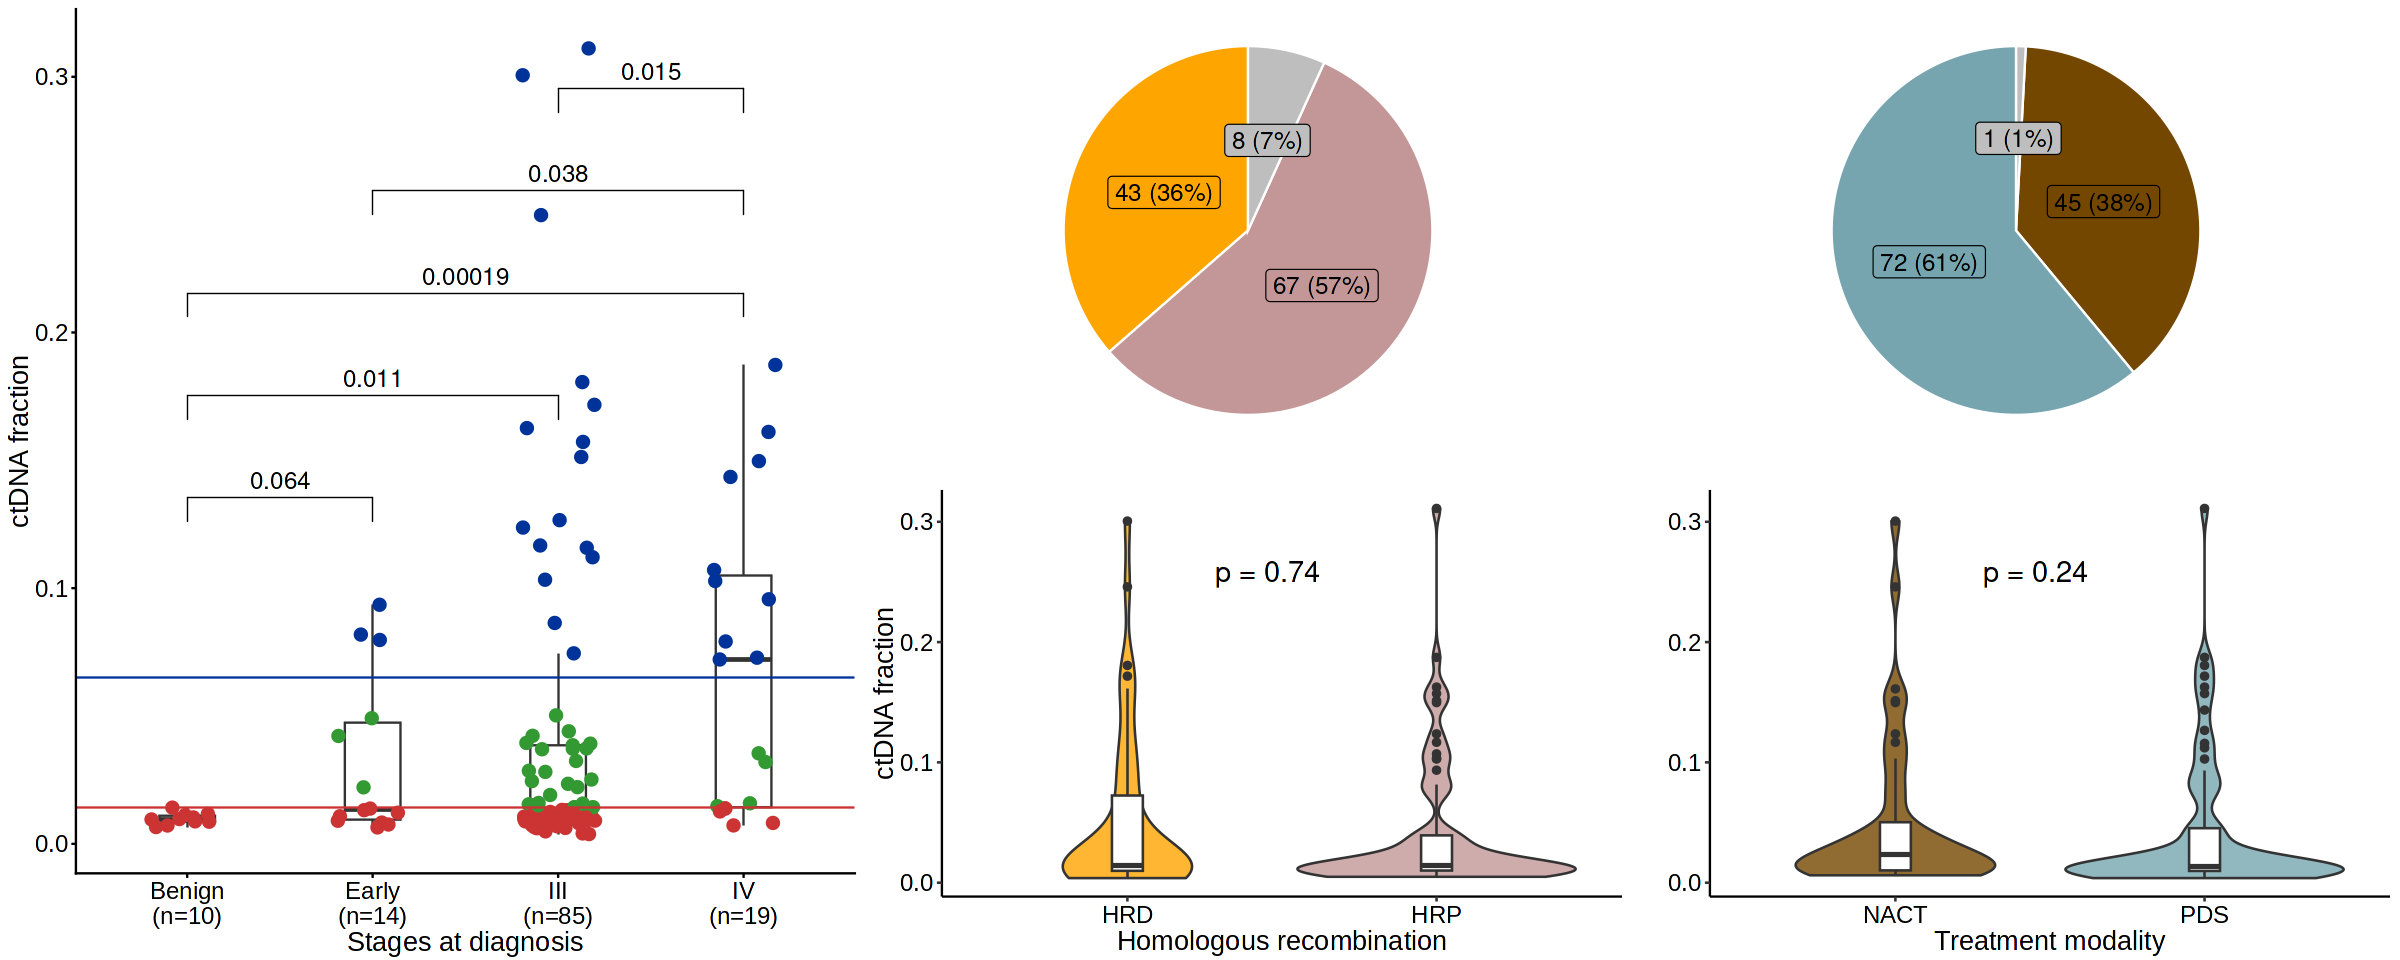

In [111]:
options(repr.plot.width = 20, repr.plot.height = 8)
suppressWarnings(ggarrange(
  fig1a, ggarrange(fig1b1, fig1b3, fig1b2, fig1b4, ncol = 2, nrow = 2),
  ncol = 2, widths = c(.36,.64)
))

#### Figure 1c: Study design

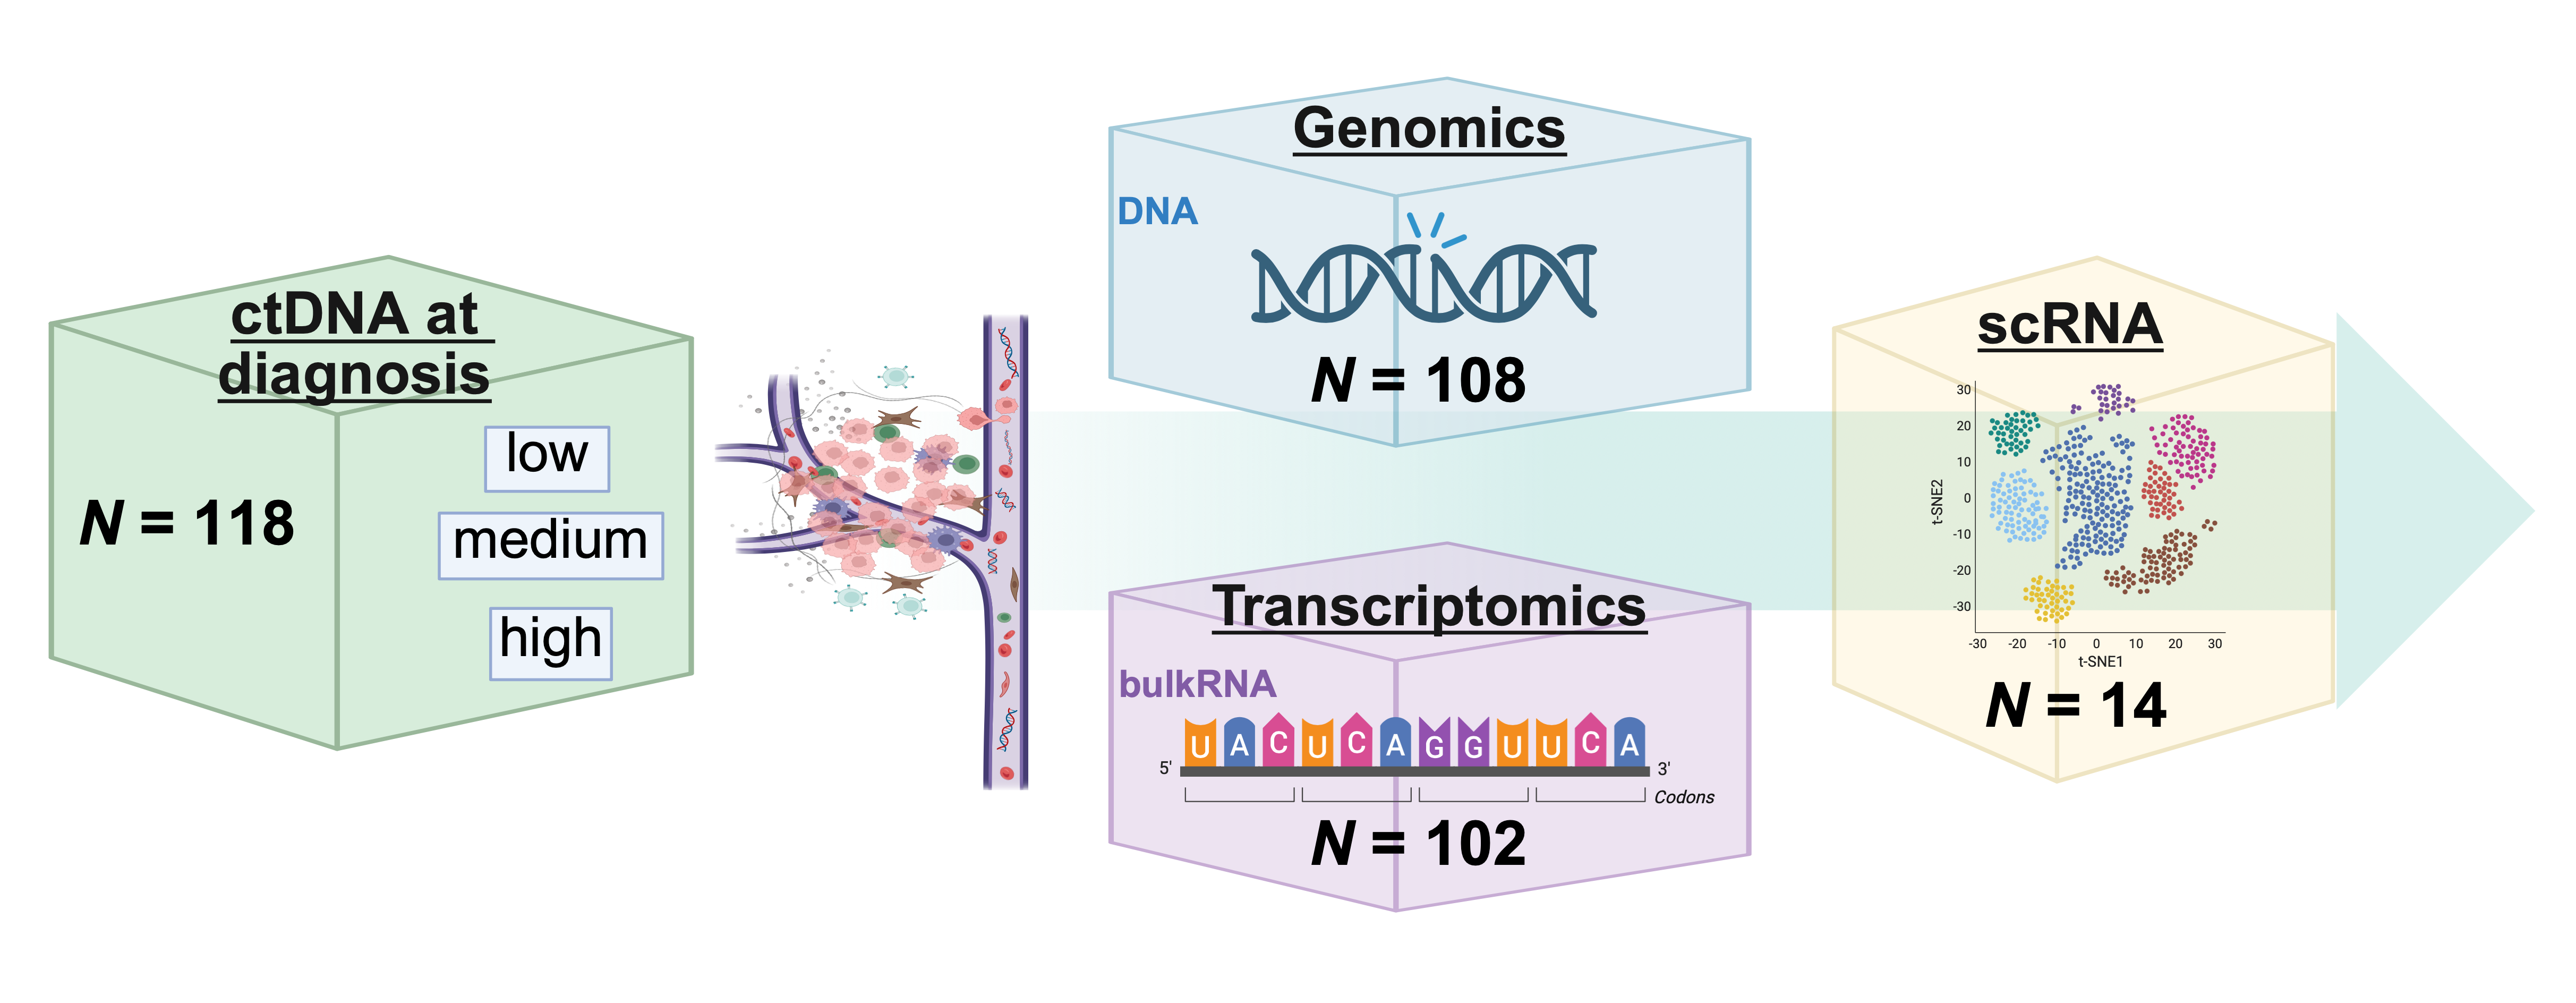

In [122]:
IRdisplay::display_png(file = paste0(project_dir,'/figures/main/1c_study_design.png'))


#### Figure 1d: Cohort summary

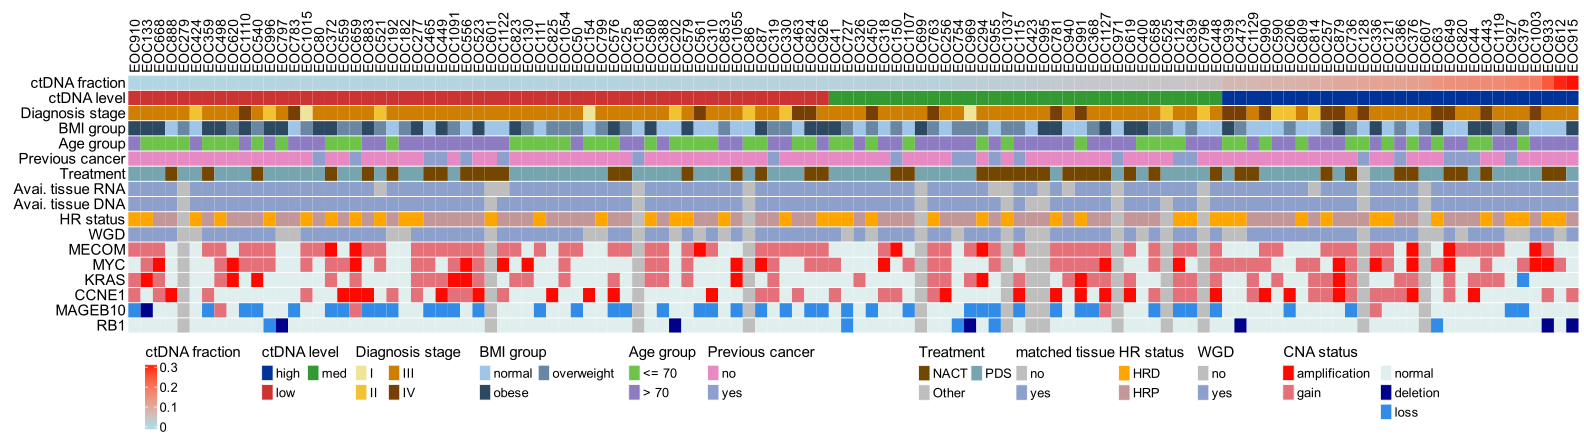

In [ ]:
options(repr.plot.width = 25, repr.plot.heigh = 10)
IRdisplay::display_svg(file = paste0(project_dir,'/figures/main/1d_cohort_info.svg'))
